<a href="https://colab.research.google.com/github/kshitijrajsharma/building-regularization-research/blob/main/building_regularization_research_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building Regularization Research

This notebook compares the different building regularization techniques and visualizes the result , This is the part of the wider research here : https://kshitijrajsharma.github.io/building-regularization-research/

#### Prepare dataset
Before comparing we need some realworld examples that we can run through . Hence in this experiment we will use OpenAerialMap as source of imagery : https://openaerialmap.org/ and RAMP https://rampml.global/ as building detection deep learning model , it was built on top of  Eff-UNet trained on over 80gb of building samples in high resolution data mainly focused on low-and-middle-income countries

In [ ]:
# Install required deps that are not natively available to collab
!pip install fairpredictor mapclassify

Lets create a function that lets allows us to visualize the imagery and the bounding box of our AOI

In [67]:
import folium
import json
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geopandas as gpd
from pathlib import Path
from folium.raster_layers import TileLayer, ImageOverlay
from predictor import DEFAULT_OAM_TMS_MOSAIC

def reproject_raster_to_wgs84(input_path, output_path=None):
    input_path = Path(input_path)
    if output_path is None:
        output_path = input_path.with_stem(input_path.stem + "_wgs84")

    with rasterio.open(input_path) as src:
        dst_crs = 'EPSG:4326'
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)

        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(output_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

    return str(output_path)


def bbox_to_geojson(bbox):
    minx, miny, maxx, maxy = bbox
    geojson_obj = {
        "type": "FeatureCollection",
        "features": [
            {
                "type": "Feature",
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [[
                        [minx, miny],
                        [maxx, miny],
                        [maxx, maxy],
                        [minx, maxy],
                        [minx, miny]
                    ]]
                },
                "properties": {}
            }
        ]
    }
    return geojson_obj


def render_map(vector_data=None, raster_path=None, tms_url=DEFAULT_OAM_TMS_MOSAIC):
    tms_name = "OpenAerialMap Mosaic Layer"
    m = folium.Map(location=[0, 0], zoom_start=2, tiles=None)
    folium.TileLayer("OpenStreetMap", name="OSM Basemap").add_to(m)

    bounds = None

    if tms_url:
        TileLayer(
            tiles=tms_url,
            name=tms_name,
            attr=tms_name,
            overlay=True,
            control=True
        ).add_to(m)

    if raster_path:
        raster_path = Path(raster_path)
        if not raster_path.exists():
            raise FileNotFoundError(f"Raster file not found: {raster_path}")
        with rasterio.open(raster_path) as src:
            b = src.bounds
            image = src.read(1)
            bounds = [[b.bottom, b.left], [b.top, b.right]]
        ImageOverlay(image=image, bounds=bounds, name="Raster Image", opacity=0.8, colormap=lambda x: (1, 0, 0, 0.6) if x == 255 else (0, 0, 0, 0)).add_to(m)
        m.fit_bounds(bounds)

    if vector_data is not None:
        if isinstance(vector_data, gpd.GeoDataFrame):
            gdf = vector_data.copy()
        elif isinstance(vector_data, (str, Path)) and Path(vector_data).exists():
            gdf = gpd.read_file(vector_data)
        elif isinstance(vector_data, str):
            gdf = gpd.GeoDataFrame.from_features(json.loads(vector_data)["features"])
        elif isinstance(vector_data, dict):
            gdf = gpd.GeoDataFrame.from_features(vector_data["features"])
        else:
            raise ValueError("Unsupported vector input type.")

        gdf = gdf.to_crs(epsg=4326) if gdf.crs else gdf.set_crs(epsg=4326)
        gdf.explore(m=m, name="Vector", style_kwds={"color": "red", "weight": 2, "fillOpacity": 0.2})
        bounds = gdf.total_bounds[[1, 0, 3, 2]].reshape(2, 2).tolist()
        m.fit_bounds(bounds)

    if tms_url:
        TileLayer(tiles=tms_url, name=tms_name, attr=tms_name, overlay=True, control=True, tms=True).add_to(m)

    folium.LayerControl().add_to(m)
    return m

## Import and run the base model

We will be running our model in dhaka (because buildings in dhaka are quite sophisticated) , You can also get your own area of interest and paste bbox here , this tool could be useful : https://kshitijrajsharma.github.io/geojson2bbox/

In [ ]:
from predictor import DEFAULT_OAM_TMS_MOSAIC, DEFAULT_RAMP_MODEL, predict

bbox = [90.4413132307426,23.69065801604559,90.4433696634461,23.692975697936987]


# lets display our input area first
map = render_map(vector_data=bbox_to_geojson(bbox))
map

## Generate prediction mask

You can uncomment following code to generate the prediction , since this module already has some regularization algorithm , I have downloaded the meta data and we will use that instead . But you can uncomment and see that metadata by yourself it would be in the merged_prediction_mask.tif

In [ ]:
# model_path = DEFAULT_RAMP_MODEL
# zoom_level = 20

# my_predictions = await predict(bbox=bbox, model_path=model_path, zoom_level=zoom_level, tms_url=DEFAULT_OAM_TMS_MOSAIC, remove_metadata=False, confidence=0.75)


In [ ]:
# map = render_map(vector_data=my_predictions)
# map

Let's download the prediction mask for our area

In [51]:
! wget https://github.com/kshitijrajsharma/building-regularization-research/raw/refs/heads/main/data/predicted_mask.tif

--2025-05-25 20:51:43--  https://github.com/kshitijrajsharma/building-regularization-research/raw/refs/heads/main/data/predicted_mask.tif
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kshitijrajsharma/building-regularization-research/refs/heads/main/data/predicted_mask.tif [following]
--2025-05-25 20:51:44--  https://raw.githubusercontent.com/kshitijrajsharma/building-regularization-research/refs/heads/main/data/predicted_mask.tif
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3969302 (3.8M) [image/tiff]
Saving to: ‘predicted_mask.tif’

predicted_mask.tif  100%[===================>]   3.79M  


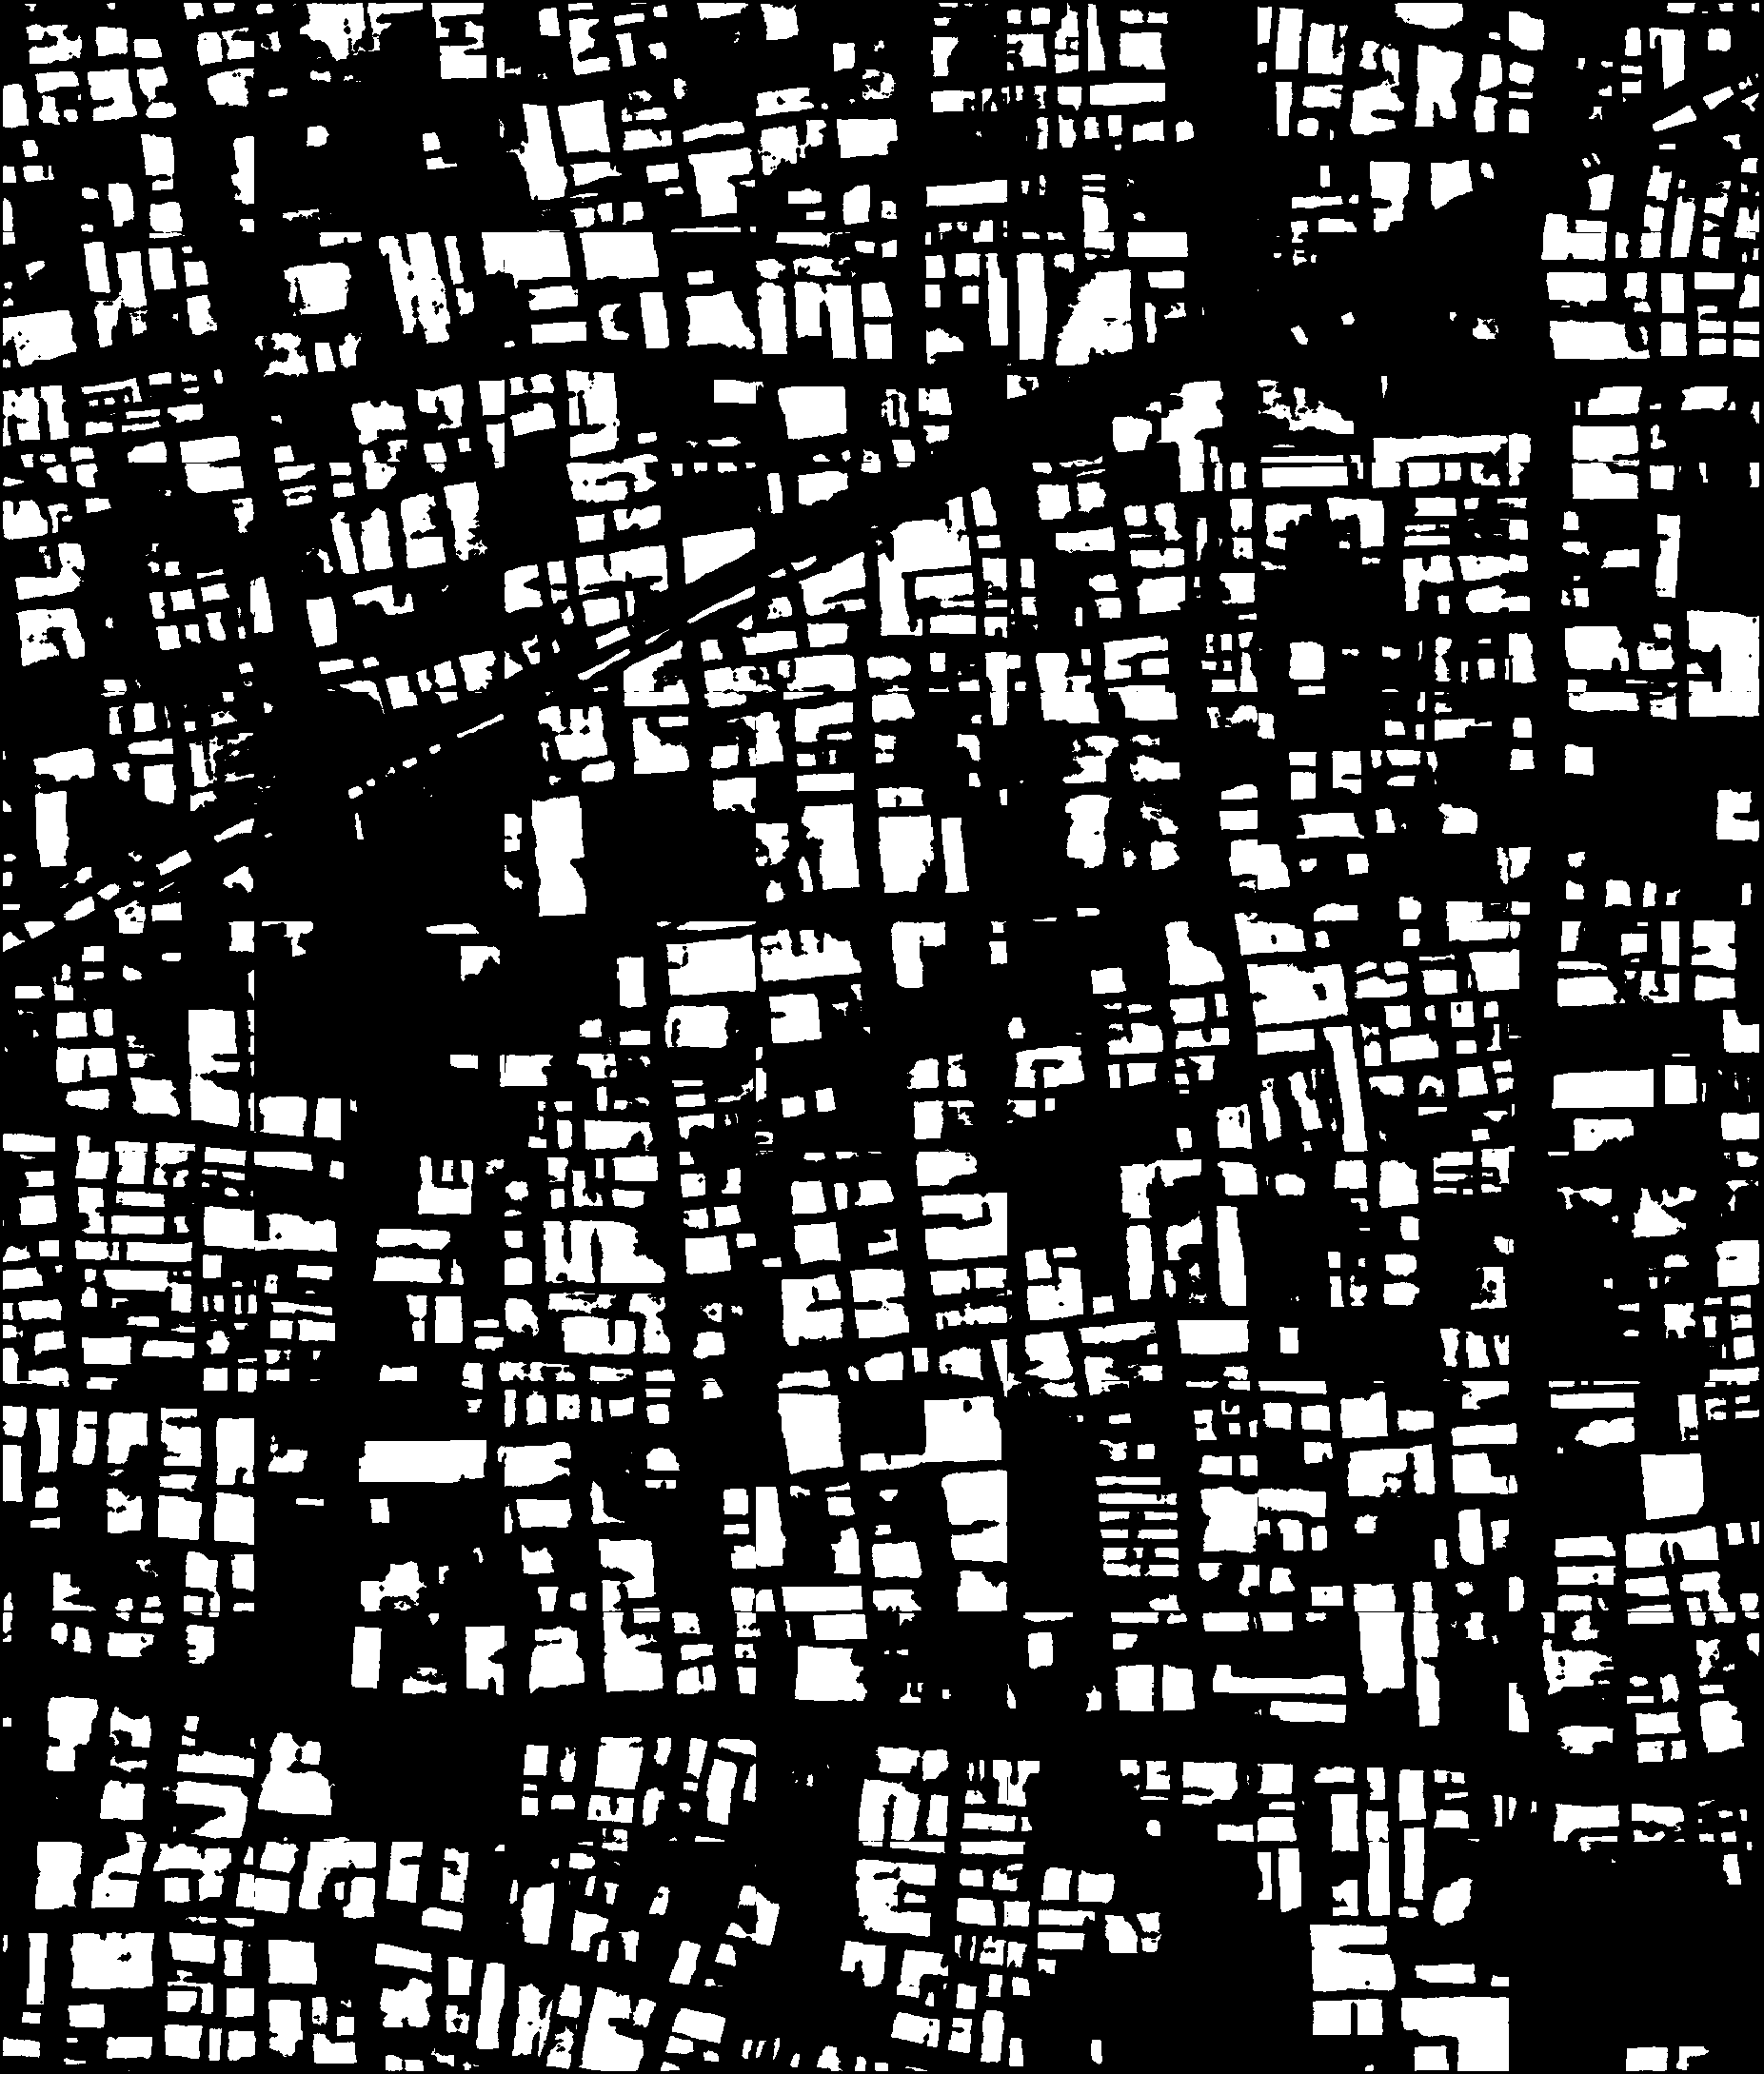

In [68]:
map = render_map(raster_path=reproject_raster_to_wgs84('predicted_mask.tif'))
map